TODO:
1. Get rid of the previous structure relying on calllbacks to process the dataset (Done)
2. 
3. load_autoregressive_traintestsplit: load multiple resolutions

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import FNO

from neuralop import Trainer
from neuralop.training import OutputEncoderCallback
from neuralop.utils import count_params
from neuralop import LpLoss, H1Loss
from neuralop.datasets import load_autoregressive_traintestsplit

device = 'cuda'

path = "./data"
data_path = str(path) + "/ns_random_forces_1.h5"

train_loader, test_loader = load_autoregressive_traintestsplit(
    data_path,
    n_train=160, n_test=40,
    batch_size=32, test_batch_size=64, 
    train_subsample_rate=4, test_subsample_rate=4,
    time_step=4,
    predict_feature='u',
)

/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/yichen/anaconda3/envs/test/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
for item in train_loader:
    print(item)
    break

{'y': tensor([[[-0.0809,  0.3994,  1.0436,  ..., -0.7246, -0.5214, -0.3199],
         [-0.0868,  0.4157,  1.0410,  ..., -0.7461, -0.5589, -0.3561],
         [-0.0878,  0.4277,  1.0312,  ..., -0.7631, -0.5892, -0.3836],
         ...,
         [-0.0324,  0.3423,  1.0158,  ..., -0.6374, -0.3737, -0.1750],
         [-0.0527,  0.3617,  1.0304,  ..., -0.6708, -0.4275, -0.2265],
         [-0.0693,  0.3810,  1.0398,  ..., -0.6995, -0.4773, -0.2759]],

        [[ 0.0581,  0.3138,  0.4713,  ..., -0.2633, -0.2212, -0.1383],
         [ 0.2377,  0.4296,  0.5656,  ..., -0.2657, -0.1813, -0.0111],
         [ 0.3774,  0.5162,  0.7930,  ..., -0.2161, -0.0662,  0.1635],
         ...,
         [-0.1088, -0.1029,  0.0545,  ..., -0.0765, -0.0528, -0.0691],
         [-0.1402, -0.0240,  0.2313,  ..., -0.1574, -0.1347, -0.1437],
         [-0.0870,  0.1404,  0.3834,  ..., -0.2235, -0.1977, -0.1782]],

        [[ 1.3722,  1.5166,  1.6609,  ...,  0.9503,  1.1638,  1.2867],
         [ 1.4924,  1.6630,  1.8163,  .

In [2]:
from neuralop.datasets.ns_contextual_sim_adapter import gen_similar_dataloader
import numpy as np

array_of_pows = np.array([-16, -8, -4, 4, 8, 16])
scale_coeffs = np.power(2., array_of_pows)

sim_test_loader = gen_similar_dataloader(train_loader, scale_coeffs)

In [5]:
# We create a tensorized FNO model
input_prods = None
n_modes=21
model = FNO(in_channels=5, n_modes=(n_modes, n_modes), hidden_channels=32, 
             projection_channels=64, factorization='tucker', rank=0.1,
             n_layers=16
             )
# width=20; num_prod=3sim_test_loader = gen_similar_dataloader(train_loader, scale_coeffs)
# model = ProdFNO_2D(in_dim=1, appended_dim=4, out_dim=1,
#                modes1=num_modes, modes2=num_modes, width=width, num_prod=num_prod, input_prods=input_prods)
# model = ProdFNO(in_channels=5, n_modes=(n_modes, n_modes), hidden_channels=32, 
#              projection_channels=64, factorization='tucker', rank=0.42)

model = model.to(device)

n_params = count_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 567265 parameters.


In [6]:
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3, 
                                weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}

print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 FNO(
  (fno_blocks): FNOBlocks1(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-31): 32 x ComplexTuckerTensor(shape=(32, 32, 10, 10), rank=(17, 17, 5, 5))
      )
    )
    (fno_skips): ModuleList(
      (0-15): 16 x Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv2d(5, 256, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

### SCHEDULER ###

### LOSSES ###

 * Train: <neuralop.t

In [7]:
import time
localtime = time.localtime(time.time())
time_now = f"{localtime.tm_mon}-{localtime.tm_mday}-{localtime.tm_hour}-{localtime.tm_min}"

In [9]:
from neuralop.training import MultipleInputCallback, SimpleTensorBoardLoggerCallback
trainer = Trainer(model=model, n_epochs=10,
                  device=device,
                  callbacks=[MultipleInputCallback(append_positional_encoding=True), SimpleTensorBoardLoggerCallback(log_dir='runs/exp_'+time_now,)],             
                  wandb_log=False,
                  log_test_interval=1,
                  use_distributed=False,
                  verbose=True)

2024-01-18 23:45:27.448280: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-18 23:45:27.576546: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-18 23:45:27.576590: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-18 23:45:27.597013: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-18 23:45:27.639823: I tensorflow/core/platform/cpu_feature_guar

using standard method to load data to device.
using standard method to compute loss.
self.override_load_to_device=False
self.overrides_loss=False


In [10]:
trainer.train(train_loader=train_loader,
              test_loader={'irrevalent': test_loader, 'similar': sim_test_loader},
              optimizer=optimizer, 
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss, 
              eval_losses=eval_losses)

Training on 31520 samples
Testing on [7880, 31520] samples         on resolutions ['irrevalent', 'similar'].
Raw outputs of size out.shape=torch.Size([32, 1, 64, 64])
[0] time=28.94, avg_loss=3152.0057, train_err=32.0001, irrevalent_h1=1.0000, irrevalent_l2=1.0000, similar_h1=1.0000, similar_l2=1.0000


KeyboardInterrupt: 

In [8]:
test_loader.dataset

In [16]:
torch.save(trainer.model, "./ckpt/TFNO_ep300.pth")

/tmp/ipykernel_13037/1837442807.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


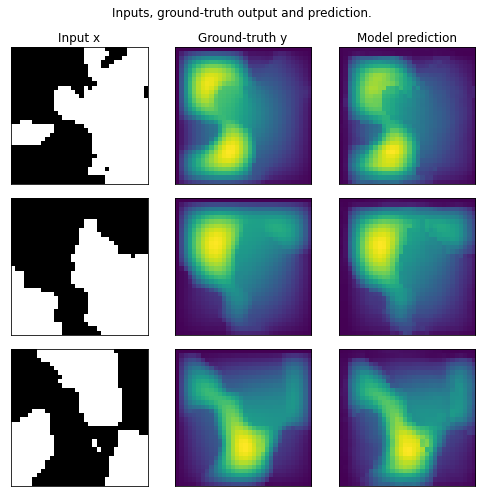

In [8]:
test_samples = test_loader.dataset

fig = plt.figure(figsize=(7, 7))
for index in range(3):
    data = test_samples[index]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y']
    # Model prediction
    out = model(x.unsqueeze(0))

    ax = fig.add_subplot(3, 3, index*3 + 1)
    ax.imshow(x[0], cmap='gray')
    if index == 0: 
        ax.set_title('Input x')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 2)
    ax.imshow(y.squeeze())
    if index == 0: 
        ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(3, 3, index*3 + 3)
    ax.imshow(out.squeeze().detach().numpy())
    if index == 0: 
        ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()

In [ ]:
/home/yichen/repo/cfd/myFNO/data/ns_contextual/